CNN MODEL


In [55]:
import pandas as pd
import torch 
from torch.utils.data import Dataset, DataLoader

In [56]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [57]:
df = pd.read_csv("dataset.csv")
print(df.head())
print(df.info())
print(len(df))


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None
50000


convert reviews(text) to tokens
convert sentiment to digit - positive = 1, negative = 0

In [58]:
df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

In [59]:
from torch.utils.data import Dataset
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
class MovieDataset(Dataset):
    def __init__(self, dataframe):
        self.texts = dataframe['review'].values
        self.labels = dataframe['sentiment'].values
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):

        token_ids = tokenizer.encode(
            self.texts[idx],
            add_special_tokens=True,
            truncation=True,
            max_length=256,
            padding='max_length'
        )
        return torch.tensor(token_ids, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)


dataset = MovieDataset(df)

In [60]:
from torch.utils.data import random_split

total_len = len(dataset)
train_len = int(0.8 * total_len)
valid_len = int(0.1 * total_len)
test_len  = total_len - train_len - valid_len

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_len, valid_len, test_len])


In [61]:
print(train_dataset[0])

(tensor([  101,  1037,  2613,  4438,  1012,  1037,  2911, 11066,  1997, 11279,
         2667,  2000,  2131,  2000,  1996,  4865,  5727,  2096,  2037, 11397,
         2175,  2000, 28800,  2000, 28283,  1996, 11279,  4740,  1012,  1037,
        10494,  2015,  5390,  2005,  4681,  3463,  1999,  1996, 18365,  1997,
         1996,  1000,  9040,  4686,  1000,  1012,  1037,  8754,  2143,  3403,
         2000,  4148,   999,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,

In [62]:
print(len(train_dataset), len(valid_dataset), len(test_dataset))

40000 5000 5000


In [63]:

batch_size = 128
train_loader_cnn = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader_cnn = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader_cnn  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

for batch in train_loader_cnn:
    inputs, labels = batch
    print(inputs.shape)
    print(labels.shape)
    break

torch.Size([128, 256])
torch.Size([128])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        n_filters,
        filter_sizes,
        output_dim,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.convs = nn.ModuleList( 
            [
                nn.Conv1d(embedding_dim, n_filters, filter_size)
                for filter_size in filter_sizes
            ]
        )
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)


        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids):
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        embedded = embedded.permute(0, 2, 1)
        # embedded = [batch size, embedding dim, seq len]
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        # conved_n = [batch size, n filters, seq len - filter_sizes[n] + 1]
        pooled = [conv.max(dim=-1).values for conv in conved]
        # pooled_n = [batch size, n filters]
        cat = self.dropout(torch.cat(pooled, dim=-1))
        # cat = [batch size, n filters * len(filter_sizes)]
        prediction = self.fc(cat)
        # prediction = [batch size, output dim]
        return prediction

In [65]:
vocab_size = tokenizer.vocab_size
embedding_dim = 300
n_filters = 100
filter_sizes = [3, 5, 7]
output_dim = 2
dropout_rate = 0.5
pad_index = tokenizer.pad_token_id
CNNModel = CNN(vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout_rate, pad_index)

In [66]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(CNNModel):,} trainable parameters")

The model has 9,607,502 trainable parameters


In [67]:
def init_weights(m):
    if isinstance(m, nn.Embedding):
        nn.init.uniform_(m.weight, -0.1, 0.1)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Conv1d):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

CNNModel.apply(init_weights)


CNN(
  (embedding): Embedding(30522, 300, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(7,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [68]:
import torch.optim as optim
optimizer = optim.Adam(CNNModel.parameters())
loss_fn = nn.CrossEntropyLoss()

In [69]:
CNNModel = CNNModel.to(device)
loss_fn = loss_fn.to(device)

In [70]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [71]:
import tqdm
import numpy as np
import torch

def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch_ids, batch_labels in tqdm.tqdm(data_loader, desc="training..."):  # unpack tuple
        batch_ids = batch_ids.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        prediction = model(batch_ids)
        loss = criterion(prediction, batch_labels)

        # calculate accuracy
        accuracy = (prediction.argmax(dim=1) == batch_labels).float().mean()

        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return np.mean(epoch_losses), np.mean(epoch_accs)

In [72]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch_ids, batch_labels in tqdm.tqdm(data_loader, desc="evaluating..."):  # unpack tuple
            batch_ids = batch_ids.to(device)
            batch_labels = batch_labels.to(device)

            prediction = model(batch_ids)
            loss = criterion(prediction, batch_labels)

            # calculate accuracy
            accuracy = (prediction.argmax(dim=1) == batch_labels).float().mean()

            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return np.mean(epoch_losses), np.mean(epoch_accs)

In [73]:
import collections
import torch

n_epochs = 3
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

CNNModel = CNNModel.to(device)  # move model to GPU/CPU

for epoch in range(n_epochs):
    train_loss, train_acc = train(train_loader_cnn, CNNModel, loss_fn, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_loader_cnn, CNNModel, loss_fn, device)

    # store metrics
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)

    # save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(CNNModel.state_dict(), "CNNModel.pt")

    print(f"Epoch: {epoch+1}")
    print(f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}")
    print(f"Valid Loss: {valid_loss:.3f}, Valid Acc: {valid_acc:.3f}")


evaluating...: 100%|██████████| 40/40 [00:03<00:00, 10.57it/s]


Epoch: 1
Train Loss: 0.576, Train Acc: 0.676
Valid Loss: 0.358, Valid Acc: 0.847


evaluating...: 100%|██████████| 40/40 [00:05<00:00,  7.66it/s]


Epoch: 2
Train Loss: 0.348, Train Acc: 0.846
Valid Loss: 0.296, Valid Acc: 0.880


evaluating...: 100%|██████████| 40/40 [00:04<00:00,  9.82it/s]

Epoch: 3
Train Loss: 0.262, Train Acc: 0.891
Valid Loss: 0.289, Valid Acc: 0.879


In [74]:
import matplotlib.pyplot as plt

def plot_metrics(metrics, n_epochs, title="Training vs Validation Metrics"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(title, fontsize=16)

    ax1.plot(metrics["train_losses"], label="train loss")
    ax1.plot(metrics["valid_losses"], label="valid loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_xticks(range(n_epochs))
    ax1.set_title("Loss")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(metrics["train_accs"], label="train acc")
    ax2.plot(metrics["valid_accs"], label="valid acc")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.set_xticks(range(n_epochs))
    ax2.set_title("Accuracy")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


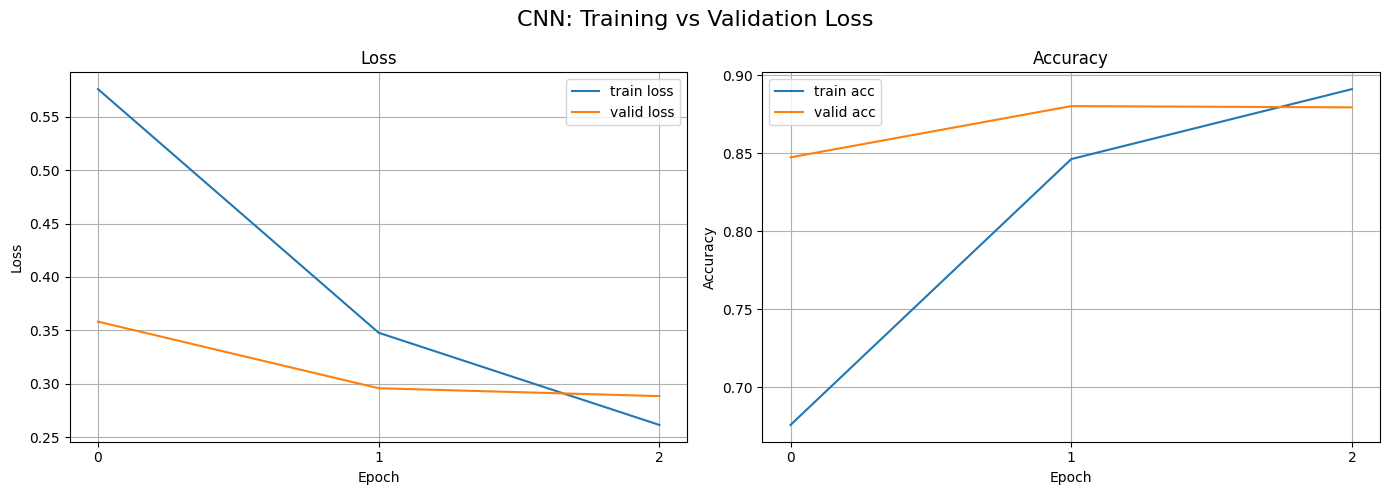

In [75]:
plot_metrics(metrics, n_epochs, title="CNN: Training vs Validation Loss")

In [76]:
test_loss, test_acc = evaluate(test_loader_cnn, CNNModel, loss_fn, device)
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")


evaluating...: 100%|██████████| 40/40 [00:05<00:00,  7.85it/s]

test_loss: 0.296, test_acc: 0.875


In [77]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    
    # Tokenize and pad
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        truncation=True,
        max_length=max_length,
        padding='max_length',
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)  # [1, seq_len]

    # Get model prediction
    with torch.no_grad():
        prediction = model(input_ids)  # [1, output_dim]
        probs = torch.softmax(prediction, dim=-1)
        predicted_class = prediction.argmax(dim=-1).item()
        predicted_prob = probs[0, predicted_class].item()
    
    return predicted_class, predicted_prob

In [78]:
text = "This film is very boring and waste of time!"
min_length = max(filter_sizes)

predict_sentiment(text, CNNModel, tokenizer, device, pad_index)

(0, 0.9995433688163757)

10 epochs, adamn, cross entropy loss, no initializing weights,embedding dim 128, drop out rate - 0.5, max len 128 - 80% test accuracy

10 epochs, adam, cross entropy loss, initializing weights, emb dim 128, drop out tate - 0.5, max len 128  - 82% (validation loss increases)

10 epochs,adam,cross,init weights, emb dim 300, drp out rate - 0.5,max len = 256  - 86%

same as above, but stopping at 3 epochs - 88%, loss - 29%



LSTM MODEL

In [79]:
class MovieDataset(Dataset):
    def __init__(self, dataframe, max_len=256):
        self.texts = dataframe['review'].tolist()
        self.labels = dataframe['sentiment'].tolist()
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            truncation=True,
            padding="max_length",   # automatically pads to max_len
            max_length=self.max_len,
            return_tensors="pt"
        )
        tokens = encoding['input_ids'].squeeze(0)  # remove batch dimension
        seq_len = (tokens != tokenizer.pad_token_id).sum().item()  # actual length
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return tokens, label, seq_len
dataset = MovieDataset(df)

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_len, valid_len, test_len])

In [80]:
batch_size = 64
max_len = 128
train_loader_lstm = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader_lstm = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader_lstm = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [81]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        bidirectional,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate if n_layers > 1 else 0.0,
            batch_first=True,
        )

        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.bidirectional = bidirectional

    def forward(self, ids, lengths):
        embedded = self.dropout(self.embedding(ids))
        
        # Pack the sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        
        # Concatenate last hidden states from both directions if bidirectional
        if self.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2], hidden[-1]), dim=1))
        else:
            hidden = self.dropout(hidden[-1])
        
        prediction = self.fc(hidden)
        return prediction


In [82]:
from torch.utils.data import DataLoader


# model
vocab_size = tokenizer.vocab_size
embedding_dim = 300
hidden_dim = 300
output_dim = 2
n_layers = 2
bidirectional = True
dropout_rate = 0.5
pad_index = tokenizer.pad_token_id

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LSTMModel = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index
).to(device)

# optimizer and loss
optimizer = torch.optim.Adam(LSTMModel.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()


In [83]:
import numpy as np
import tqdm
import torch

def train_LSTM(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch_ids, batch_labels, lengths in tqdm.tqdm(data_loader, desc="training..."):
        batch_ids = batch_ids.to(device)
        batch_labels = batch_labels.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        prediction = model(batch_ids, lengths)
        loss = criterion(prediction, batch_labels)

        accuracy = (prediction.argmax(dim=1) == batch_labels).float().mean()

        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return np.mean(epoch_losses), np.mean(epoch_accs)

def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch_ids, batch_labels, lengths in tqdm.tqdm(data_loader, desc="evaluating..."):
            batch_ids = batch_ids.to(device)
            batch_labels = batch_labels.to(device)
            lengths = lengths.to(device)

            prediction = model(batch_ids, lengths)
            loss = criterion(prediction, batch_labels)
            accuracy = (prediction.argmax(dim=1) == batch_labels).float().mean()

            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return np.mean(epoch_losses), np.mean(epoch_accs)


In [84]:
n_epochs = 10
best_valid_loss = float("inf")
LSTM_metrics = collections.defaultdict(list)
for epoch in range(n_epochs):
    train_loss, train_acc = train_LSTM(train_loader_lstm, LSTMModel, loss_fn, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_loader_lstm, LSTMModel, loss_fn, device)

    LSTM_metrics['train_losses'].append(train_loss)
    LSTM_metrics['train_accs'].append(train_acc)
    LSTM_metrics['valid_losses'].append(valid_loss)
    LSTM_metrics['valid_accs'].append(valid_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(LSTMModel.state_dict(), "LSTMModel.pt")
    
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f} | Valid Loss: {valid_loss:.3f}, Valid Acc: {valid_acc:.3f}")


evaluating...: 100%|██████████| 79/79 [00:07<00:00, 10.90it/s]


Epoch 1 | Train Loss: 0.681, Train Acc: 0.560 | Valid Loss: 0.606, Valid Acc: 0.661


evaluating...: 100%|██████████| 79/79 [00:08<00:00,  9.05it/s]


Epoch 2 | Train Loss: 0.627, Train Acc: 0.643 | Valid Loss: 0.435, Valid Acc: 0.809


evaluating...: 100%|██████████| 79/79 [00:09<00:00,  8.76it/s]


Epoch 3 | Train Loss: 0.438, Train Acc: 0.801 | Valid Loss: 0.413, Valid Acc: 0.821


evaluating...: 100%|██████████| 79/79 [00:06<00:00, 11.47it/s]


Epoch 4 | Train Loss: 0.344, Train Acc: 0.852 | Valid Loss: 0.308, Valid Acc: 0.869


evaluating...: 100%|██████████| 79/79 [00:07<00:00, 10.73it/s]


Epoch 5 | Train Loss: 0.303, Train Acc: 0.873 | Valid Loss: 0.295, Valid Acc: 0.880


evaluating...: 100%|██████████| 79/79 [00:08<00:00,  8.87it/s]


Epoch 6 | Train Loss: 0.269, Train Acc: 0.890 | Valid Loss: 0.270, Valid Acc: 0.890


evaluating...: 100%|██████████| 79/79 [00:08<00:00,  9.12it/s]


Epoch 7 | Train Loss: 0.246, Train Acc: 0.900 | Valid Loss: 0.299, Valid Acc: 0.888


evaluating...: 100%|██████████| 79/79 [00:07<00:00, 10.64it/s]


Epoch 8 | Train Loss: 0.226, Train Acc: 0.910 | Valid Loss: 0.280, Valid Acc: 0.895


evaluating...: 100%|██████████| 79/79 [00:08<00:00,  9.87it/s]


Epoch 9 | Train Loss: 0.204, Train Acc: 0.920 | Valid Loss: 0.275, Valid Acc: 0.900


evaluating...: 100%|██████████| 79/79 [00:07<00:00, 10.72it/s]

Epoch 10 | Train Loss: 0.193, Train Acc: 0.924 | Valid Loss: 0.286, Valid Acc: 0.900


In [85]:
test_loss, test_acc = evaluate(test_loader_lstm, LSTMModel, loss_fn, device)
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

evaluating...: 100%|██████████| 79/79 [00:07<00:00, 10.01it/s]

test_loss: 0.308, test_acc: 0.895


In [86]:
print("Train losses:", LSTM_metrics.get("train_losses"))
print("Valid losses:", LSTM_metrics.get("valid_losses"))


Train losses: [0.6807964208602906, 0.6266719698905945, 0.437684143614769, 0.3435936138391495, 0.30269094219207765, 0.2691782523751259, 0.2463691355228424, 0.22591522619724275, 0.2039830982863903, 0.1932368692278862]
Valid losses: [0.6064651336850999, 0.4347725899159154, 0.4134926577157612, 0.30845106383667714, 0.29479609825943087, 0.26951100017073787, 0.29903810584469687, 0.2800772538102126, 0.2747532750798177, 0.2861577760946902]


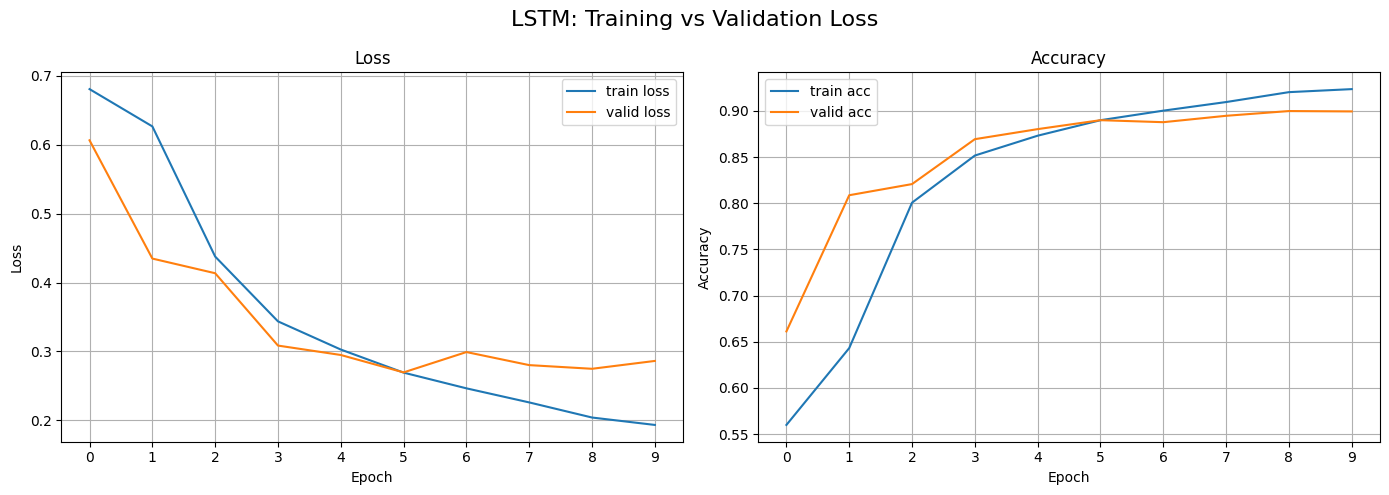

In [87]:
plot_metrics(LSTM_metrics, n_epochs, title="LSTM: Training vs Validation Loss")

In [88]:
#Loading the best models
LSTMModel.load_state_dict(torch.load("LSTMModel.pt"))
CNNModel.load_state_dict(torch.load("CNNModel.pt"))

<All keys matched successfully>

# Comparing the Model on different Metrics

In [89]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(data_loader, model, device, is_lstm=False):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            if is_lstm:
                batch_ids, batch_labels, lengths = batch
                batch_ids, batch_labels, lengths = batch_ids.to(device), batch_labels.to(device), lengths.to(device)
                preds = model(batch_ids, lengths)
            else:
                batch_ids, batch_labels = batch
                batch_ids, batch_labels = batch_ids.to(device), batch_labels.to(device)
                preds = model(batch_ids)

            all_preds.append(preds.argmax(dim=1).cpu())
            all_labels.append(batch_labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    cm = confusion_matrix(all_labels, all_preds)

    return acc, prec, rec, f1,cm


In [90]:
cnn_metrics = evaluate_model(test_loader_cnn, CNNModel, device, is_lstm=False)
lstm_metrics = evaluate_model(test_loader_lstm, LSTMModel, device, is_lstm=True)


print("CNN Model Metrics - Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}\n Confusion Matrix: \n{}".format(*cnn_metrics))
print("LSTM Model Metrics - Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}\n Confusion Matrix: \n{}".format(*lstm_metrics))

CNN Model Metrics - Accuracy: 0.878, Precision: 0.861, Recall: 0.902, F1: 0.881
 Confusion Matrix: 
[[2139  364]
 [ 245 2252]]
LSTM Model Metrics - Accuracy: 0.885, Precision: 0.886, Recall: 0.880, F1: 0.883
 Confusion Matrix: 
[[2258  280]
 [ 295 2167]]


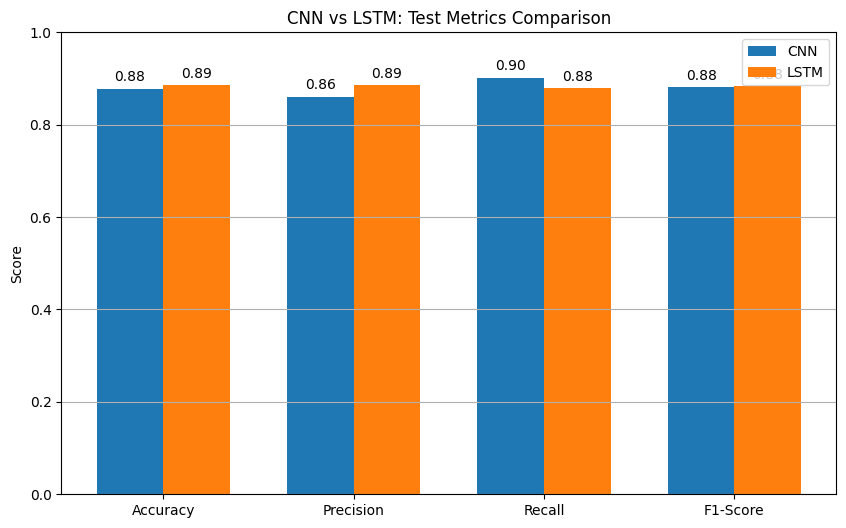

In [91]:
#visualize metrics
import matplotlib.pyplot as plt
import numpy as np

labels = ["Accuracy", "Precision", "Recall", "F1-Score"]
modelA_vals = cnn_metrics[:-1]  # no need conf matrix
modelB_vals = lstm_metrics[:-1]  

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, modelA_vals, width, label='CNN')
rects2 = ax.bar(x + width/2, modelB_vals, width, label='LSTM')

ax.set_ylabel('Score')
ax.set_ylim(0, 1)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('CNN vs LSTM: Test Metrics Comparison')
ax.legend()
ax.grid(axis='y')

# Annotate bars
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show()

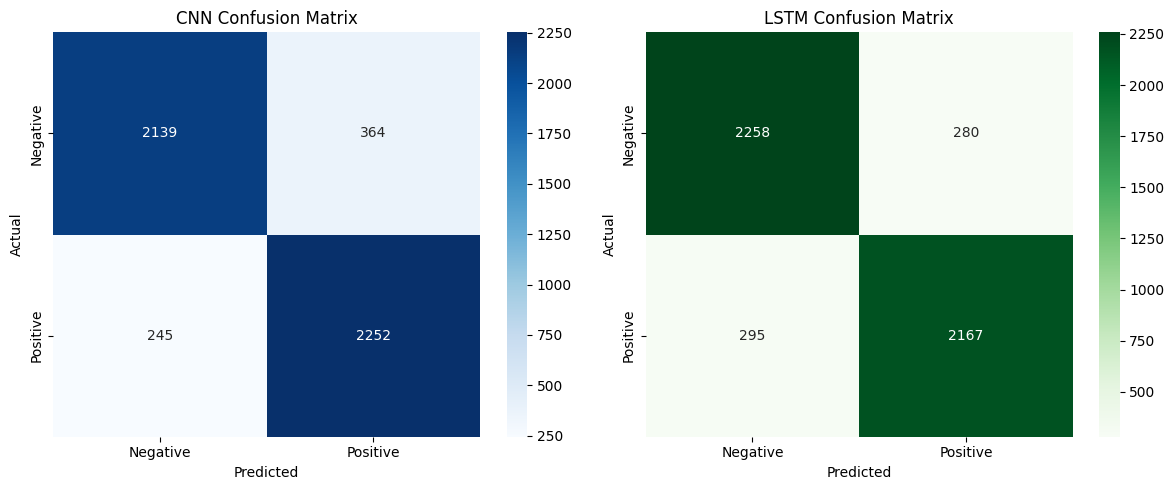

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

cnn_cm = cnn_metrics[-1]
lstm_cm = lstm_metrics[-1]

class_names = ["Negative", "Positive"]

fig, axs = plt.subplots(1, 2, figsize=(12,5))  # 1 row, 2 columns

# CNN confusion matrix
sns.heatmap(cnn_cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=axs[0])
axs[0].set_title("CNN Confusion Matrix")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

# LSTM confusion matrix
sns.heatmap(lstm_cm, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names, ax=axs[1])
axs[1].set_title("LSTM Confusion Matrix")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()
